In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import pickle
import os

from sklearn.utils import resample
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters

In [2]:
path = '../data/prompt_engineering/'
files = os.listdir(path)
files = [f for f in files if 'explain' not in f]  # exclude explain file
files = np.array(files)[[0, 4, 3, 1, 2]]  # custom order

In [3]:
data = {}
for file in files:
    with open(path + file, 'rb') as f:
        file_data = pickle.load(f)
    entry = [[x.choices[0].message.content for x in n] for n in file_data]
    entry = [[x.lower().strip().replace('.', '') for x in n] for n in entry]  # clean entries
    data[file] = entry

In [4]:
with open('../data/Cit-HepPh.txt', 'r') as f:
    for _ in range(4):
        next(f)
    edges = f.readlines()
edges = [edge.strip().split('\t') for edge in edges]

start = 0
end = len(edges)
size = 100
np.random.seed(42)
idx = np.random.uniform(start, end, size=size).astype(int)
edges = np.array(edges)
edges = edges[idx]

df_data = {
    'source': edges[:, 0],
    'target': edges[:, 1]
}
for key in data.keys():
    df_data[key] = np.array(data[key]).T.tolist()
    
df = pd.DataFrame(df_data)

In [5]:
# mode
for file in files:
    df['mode_' + file] = df[file].apply(lambda x: max(set(x), key=x.count))

In [6]:
df.head()

,source,target,baseline_gpt-3.5-turbo.pkl,simple_gpt-3.5-turbo.pkl,medium_gpt-3.5-turbo.pkl,final_gpt-3.5-turbo.pkl,final_gpt-4-1106-preview.pkl,mode_baseline_gpt-3.5-turbo.pkl,mode_simple_gpt-3.5-turbo.pkl,mode_medium_gpt-3.5-turbo.pkl,mode_final_gpt-3.5-turbo.pkl,mode_final_gpt-4-1106-preview.pkl
0,201302,9911437,"[disagreement, disagreement, disagreement, dis...","[agreement, disagree, disagreement, disagree, ...","[disagreement, disagreement, agreement, disagr...","[disagreement, disagreement, disagreement, neu...","[neutral, neutral, neutral, neutral, neutral]",disagreement,disagreement,disagreement,disagreement,neutral
1,111195,104088,"[agreement, agreement, agreement, disagreement...","[agreement, agreement, disagree, disagree, agr...","[disagreement, disagreement, disagreement, neu...","[disagreement, agreement, disagreement, disagr...","[neutral, neutral, neutral, neutral, neutral]",agreement,agreement,disagreement,disagreement,neutral
2,9905533,9502289,"[neutral, neutral, agreement, neutral, disagre...","[agreement, disagree, agreement, no, disagree]","[disagreement, disagreement, disagreement, dis...","[disagreement, disagreement, disagreement, dis...","[neutral, neutral, neutral, neutral, neutral]",neutral,disagree,disagreement,disagreement,neutral
3,112347,108224,"[disagreement, neutral, neutral, disagreement,...","[disagree, no, no, disagree, disagree]","[agreement, agreement, disagreement, disagreem...",[the abstract of paper a does not mention pape...,"[neutral, neutral, neutral, neutral, neutral]",neutral,disagree,agreement,neutral,neutral
4,201291,111418,"[neutral, disagreement, disagreement, disagree...","[agreement, agreement, the papers do not agree...","[disagreement, disagreement, disagreement, dis...","[disagreement, disagreement, agreement, disagr...","[neutral, neutral, neutral, neutral, neutral]",disagreement,agreement,disagreement,disagreement,neutral


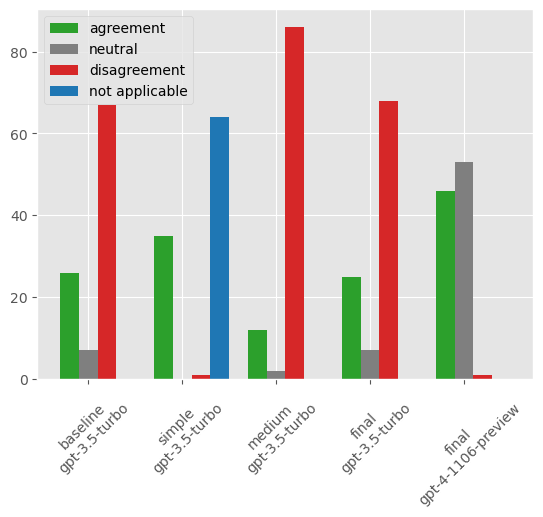

In [7]:
# mode plot
labels = ['\n'.join(file.split('_')).replace('.pkl', '') for file in files]

fig, ax = plt.subplots()

agree_counts = [(df['mode_'+file] == 'agreement').sum() for file in files]
neutral_counts = [(df['mode_'+file] == 'neutral').sum() for file in files]
disagree_counts = [(df['mode_'+file] == 'disagreement').sum() for file in files]
nota_counts = [((df['mode_'+file] != 'agreement') & (df['mode_'+file] != 'neutral') & (df['mode_'+file] != 'disagreement')).sum() for file in files]

x_pos = np.arange(len(files))
width = 0.2

ax.bar(x_pos - width, agree_counts, width, label='agreement', color='tab:green')
ax.bar(x_pos, neutral_counts, width, label='neutral', color='tab:grey')
ax.bar(x_pos + width, disagree_counts, width, label='disagreement', color='tab:red')
ax.bar(x_pos + 2*width, nota_counts, width, label='not applicable', color='tab:blue')

ax.set_xticklabels(['why the fuck does this not appear???? This is just here for padding for some unknown reason']+labels, rotation=45)

ax.legend()

In [8]:
kappas = {}
for key in data.keys():
    x = np.array(data[key]).T
    arr, categories = aggregate_raters(x)
    print(key, categories)
    kappas[key] = fleiss_kappa(arr)
    
# bootstrap
n_bootstraps = 1000
bootstrapped_kappas = {}
for key in data.keys():
    b_kappas = []
    for i in range(n_bootstraps):
        x = resample(np.array(data[key]).T)
        arr, categories = aggregate_raters(x)
        b_kappas.append(fleiss_kappa(arr))
    bootstrapped_kappas[key] = b_kappas

baseline_gpt-3.5-turbo.pkl ['agreement' 'disagreement' 'neutral'
 'the agreement between paper a and paper b is unclear'
 'the papers are in agreement'
 'the word agreement can be used to evaluate the relationship'
 'the words in paper a suggest that the authors believe']
simple_gpt-3.5-turbo.pkl ['agree' 'agreed' 'agreement' 'agreement between the papers: no'
 'agreement: disagree' 'agreement: limited' 'agreement: no'
 'agreement: partial' 'agreement: partially' 'agreement: yes' 'agrees'
 'disagree' 'disagreement' 'no' 'the abstracts of paper a and paper b do'
 'the answer is "no"'
 'the answer is unclear as there is not enough information'
 'the papers agree' 'the papers agree: yes'
 'the papers are not in agreement' 'the papers disagree'
 'the papers do **not** agree' 'the papers do not agree'
 'the papers partially agree' 'the two papers do not agree' 'yes']
medium_gpt-3.5-turbo.pkl ['agreement' 'disagreement' 'neutral' 'the papers are in disagreement'
 'the papers disagree']
final

Text(0, 0.5, 'Prompt and Model')

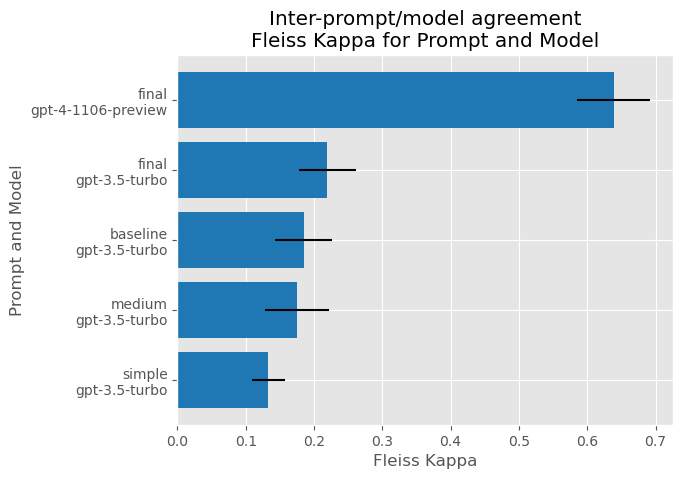

In [9]:
fig, ax = plt.subplots()
x, y = zip(*kappas.items())
idx = np.argsort(y)
x = np.array(x)[idx]
y = np.array(y)[idx]
std = np.std(list(bootstrapped_kappas.values()), axis=1)
std = std[idx]
x = ['\n'.join(xx.replace('.pkl', '').split('_')) for xx in x]
ax.barh(x, y, xerr=std, color='tab:blue')
ax.set_title('Inter-prompt/model agreement\nFleiss Kappa for Prompt and Model')
ax.set_xlabel('Fleiss Kappa')
ax.set_ylabel('Prompt and Model')